__Sequence to Sequence for Neural Machne Translation.__

*This notebook is based on [open-source implementation](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) of seq2seq NMT in PyTorch.*

We are going to implement the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper. 

The model will be trained for German to English translations, but it can be applied to any problem that involves going from one sequence to another, such as summarization.

In [1]:
import time
import random
import math
import gzip
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import pandas as pd
from sklearn.model_selection import train_test_split
import spacy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter

In [3]:
from torchtext.data import Field
from torchtext.data import BucketIterator

from torchtext.data import Example
from torchtext.data import TabularDataset

In [4]:
# matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
# %matplotlib inline

---

In [5]:
# список фраз на английском с переводом на русский
with gzip.open('../data/rus-eng/rus.txt.gz', 'rt', encoding='utf-8') as f:
    data = f.read().split('\n')
print(len(data))
data = pd.DataFrame([ s.split('\t') for s in data ],columns=['src','trg'])
data.sample(3)

336667


,src,trg
229772,Don't you feel happy and relaxed?,Вы разве не чувствуете себя счастливыми и расс...
148165,Why don't you take a seat?,Почему бы тебе не присесть?
254244,The child threw a stone at the cat.,Ребёнок бросил камень в кота.


In [6]:
# ограничиваем набор данных для ускорения процесса
data = data.sample(50000).reset_index(drop=True)

In [7]:
# !mkdir tmp

In [8]:
data.to_csv('tmp/data_train.csv', index=False, sep='\t')

---

In [9]:
# инициализируем пакет Torch
SEED = 8432
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [10]:
# создаём препроцессор для текстов
spacy_en = spacy.load('en_core_web_sm')
spacy_ru = spacy.load('ru_core_news_sm')

def tokenize_en(text): return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_ru(text): return [tok.text for tok in spacy_ru.tokenizer(text)]

SRC = Field(tokenize = tokenize_en, init_token = '<sos>', eos_token = '<eos>', lower = True)
TRG = Field(tokenize = tokenize_ru, init_token = '<sos>', eos_token = '<eos>', lower = True)

/usr/lib/python3.9/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
# загружаем датасет в формате Torch
# и выполняем предобработку данных
fields = [('src',SRC),('trg',TRG)]
(train_data,) = TabularDataset.splits(
                            path = 'tmp',
                            train = 'data_train.csv',
                            format = 'tsv', #'tsv' for tabs, 'csv' for commas
                            fields = fields
)

/usr/lib/python3.9/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/lib/python3.9/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [12]:
# количество примеров
len(train_data.examples)

50001

In [13]:
# словари 
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# раскидываем данные по батчам,
# в один батч будут помещены тексты одинаковой (или близкой) длинны

BATCH_SIZE = 128

(train_iterator,) = BucketIterator.splits(
    (train_data,), 
    batch_size = BATCH_SIZE, 
    device = device)

/usr/lib/python3.9/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [16]:
# # пример батча
# for x in train_iterator:  break
# print(x)
# print(x.src.shape, x.trg.shape)

In [17]:
# строим модель

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        
    def forward(self, src):
        embedded = self.embedding(src)
        output, (hidden, cell) = self.rnn(embedded)
        # return output,hidden, cell
        return hidden, cell    

In [19]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim ):
        super().__init__()
        
        self.embedding = nn.Embedding(output_dim,emb_dim)
        self.rnn =  nn.LSTM(emb_dim,hid_dim)
        self.out = nn.Linear(hid_dim,output_dim)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        #input = [1, batch size]

        embedded = self.embedding(input)
        #embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
               
        prediction = self.out(output.squeeze(0))
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, trg_vocab_size):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.trg_vocab_size = trg_vocab_size
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        # trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, self.trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

In [21]:
# собираем модель из частей

In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device,OUTPUT_DIM).to(device)

In [23]:
# инициализация модели
def init_weights(m): 
    for p in m.parameters():
        nn.init.uniform_(p,-.08,.08)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5007, 256)
    (rnn): LSTM(256, 512)
  )
  (decoder): Decoder(
    (embedding): Embedding(10186, 256)
    (rnn): LSTM(256, 512)
    (out): Linear(in_features=512, out_features=10186, bias=True)
  )
)

In [24]:
# метод оптимизации
optimizer = optim.Adam(model.parameters())

In [25]:
# функция потери
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [26]:
# процедура обучения
def train(model, 
          iterator, 
          optimizer, 
          criterion, 
          clip, 
          train_history=None, 
          ):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        
        # clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
                      
    return epoch_loss / len(iterator)

In [27]:
train_history = []

In [28]:
%%time

N_EPOCHS = 20
CLIP = 1

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, 
                       train_iterator, 
                       optimizer, 
                       criterion, 
                       CLIP, 
                       train_history, 
                      )
       
    train_history.append(train_loss)

    print(f'Epoch: {epoch+1:02}\tTrain Loss: {train_loss:.3f}')

/usr/lib/python3.9/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01	Train Loss: 5.023
Epoch: 02	Train Loss: 4.174
Epoch: 03	Train Loss: 3.669
Epoch: 04	Train Loss: 3.220
Epoch: 05	Train Loss: 2.824
Epoch: 06	Train Loss: 2.457
Epoch: 07	Train Loss: 2.159
Epoch: 08	Train Loss: 1.885
Epoch: 09	Train Loss: 1.637
Epoch: 10	Train Loss: 1.437
Epoch: 11	Train Loss: 1.259
Epoch: 12	Train Loss: 1.109
Epoch: 13	Train Loss: 0.968
Epoch: 14	Train Loss: 0.874
Epoch: 15	Train Loss: 0.770
Epoch: 16	Train Loss: 0.686
Epoch: 17	Train Loss: 0.617
Epoch: 18	Train Loss: 0.538
Epoch: 19	Train Loss: 0.482
Epoch: 20	Train Loss: 0.423
CPU times: user 20min 23s, sys: 3min 9s, total: 23min 32s
Wall time: 16min 29s


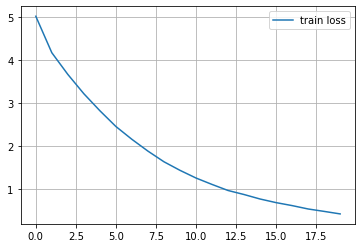

In [37]:
plt.grid()
plt.plot(train_history,label='train loss')
plt.legend()

---

In [29]:
def translate_sentence(sentence, 
                       src_field, 
                       trg_field, 
                       model, 
                       device, 
                       max_len=50,
                       spacy_lang_mod = 'ru_core_news_sm'
                      ):
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load(spacy_lang_mod)
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():  hidden, cell = model.encoder(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for t in range(1, max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]: break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [30]:
def get_example_translation():
    example_idx = np.random.choice(np.arange(len(train_data)))
    src = vars(train_data.examples[example_idx])['src']
    trg = vars(train_data.examples[example_idx])['trg']
    translation = translate_sentence(src, SRC, TRG, model, device)
   
    return [' '.join(src),' '.join(trg),' '.join(translation)]

In [31]:
from tabulate import tabulate 

tabulate(
    [ get_example_translation() for i in range(20) ], 
    headers=['src', 'trg', 'pred'], 
    tablefmt='html', 
    showindex='always'
)

,src,trg,pred
0,climb onto the roof .,заберись на крышу .,<unk> на крышу . <eos>
1,do you have your guitar with you ?,у тебя есть с собой гитара ?,у тебя есть с собой гитара ? <eos>
2,the first girl i ever kissed was mary .,"первой девочкой , которую я поцеловал , была мэри .","первой девочкой , которую я поцеловал поцеловал мэри . <eos>"
3,i wish you 'd been there .,"хотелось бы мне , чтобы вы были там .","я бы хотел , чтобы ты была там . <eos>"
4,what do you say ?,что вы говорите ?,что ты говорите ? <eos>
5,i do n't drink now .,я теперь не пью .,я не сейчас . <eos>
6,i got your messages .,я получил твои сообщения .,я получил твои сообщения . <eos>
7,i still have to pay the phone bill .,мне ещё счёт за телефон оплачивать .,мне ещё раз добраться оплачивать дорогу до темноты . <eos>
8,i was inspired by tom .,меня вдохновил том .,меня вдохновил том . <eos>
9,tom said mary was mistaken .,"том сказал , что мэри ошибается .","том сказал , что мэри ошибается . <eos>"
